# Новостной мониторинг
**Задача:** Найти в большом потоке новости, в которых есть информация о событии.

**Дано:**

* Обучающая выборка *train_data.csv*
* Новостной поток за несколько дней *test_data.csv*

Основная задача новостного мониторинга -- обрабатывать входящий поток новостей, находя в них интересные пользователям события.
В задании предлагается построить модель для выявления в новости **события**, соответствующего **задержке ввода некоторого объекта в эксплуатацию**.

Структура train_data.csv:

* id - единица данных
* sentence - текст
* label - включает ли текст требуемое условие

Структура test.csv:
* id - единица данных
* title - заголовок
* text - содержание


# Способы оценки полученных результатов?

Для оценки результатов можно использовать accuracy, recall, F1 и ROC-UAC.
Будем больше ориентироваться на метрику recall, чтобы минимизировать шансы упустить важную новость.

# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# Загрузка обучающей выборки
train_data = pd.read_csv('/content/drive/MyDrive/test_task/test_task/train_data.csv', index_col="Unnamed: 0")

In [ ]:
# Загрузка новостного потока
test_data = pd.read_csv('/content/drive/MyDrive/test_task/test_task/test_data.csv', encoding_errors='ignore', index_col="Unnamed: 0")

In [ ]:
# Просмотр первых нескольких строк для оценки данных
print("Обучающая выборка:")
train_data.head()

Обучающая выборка:


,sentence,label
0,Срыв сроков строительства зоопарка оценили в 1...,1
1,"По данным Генпрокуратуры РФ, в 2014-2018 годах...",1
2,"Обвиняли в этом столичный акимат, который сорв...",1
3,Запуск циклотронного центра ядерной медицины н...,1
4,Сроки сдачи объекта несколько раз переносились.,1


In [ ]:
train_data['label'].value_counts()

0    1340
1     329
Name: label, dtype: int64

Имеется дисбаланс классов.

In [ ]:
print("\nНовостной поток:")
test_data.head()


Новостной поток:


,id,title,text
0.0,0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...
1.0,1,На МЦД улучшили поезда,"В Москве, на Белорусско-Савеловском центрально..."
2.0,2,Катастрофа SSJ 100: вина за гибель 41 человека...,Завершено расследование дела о крушении самоле...
3.0,3,С Днем юриста!,От души поздравляем сотрудников и преподавател...
4.0,4,"Охота на ""черного"" лесоруба","В Костроме прошел межрегиональный форум, посвя..."


# EDA

* Анализ статистики текста. Включает анализ частоты слов, длины предложений, средней длины слов и других характеристик текста. Для визуализации статистики можно использовать гистограммы и диаграммы.


## Статистический анализ

In [ ]:
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Обработка тренировочных данных

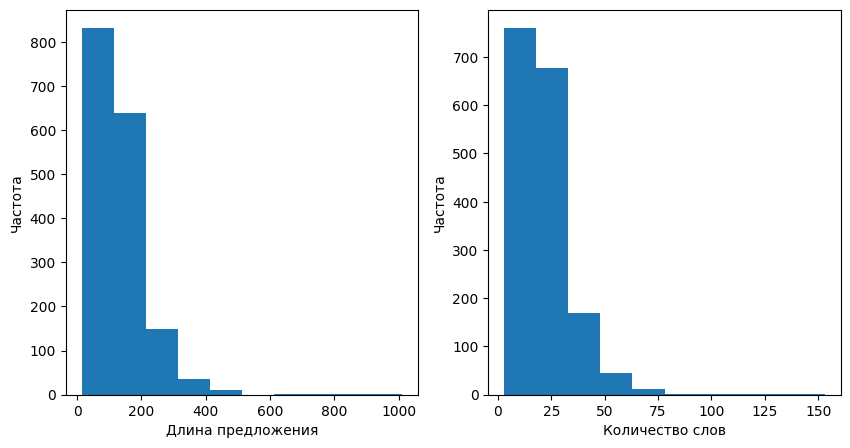

In [ ]:
# Анализ статистики текста
statistical_data = {}
statistical_data['sentence_length'] = train_data['sentence'].apply(lambda x: len(x))
statistical_data['word_count'] = train_data['sentence'].apply(lambda x: len(word_tokenize(x)))

# Визуализация статистики
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

# Построение первого графика
ax[0].hist(statistical_data['sentence_length'], bins=10)
ax[0].set_xlabel('Длина предложения')
ax[0].set_ylabel('Частота')

# Построение второго графика
ax[1].hist(statistical_data['word_count'], bins=10)
ax[1].set_xlabel('Количество слов')
ax[1].set_ylabel('Частота')
plt.show()

In [ ]:
from collections import Counter
def most_common_words(data, feild):
  corpus = ' '.join(data[feild])
  # Токенизация текста
  tokens = word_tokenize(corpus)
  # Расчет частотности слов
  word_freq = Counter(tokens)

  # Построение гистограммы наиболее частых слов
  print(word_freq.most_common(20))
  top_words = word_freq.most_common(20)
  words, freq = zip(*top_words)
  plt.figure(figsize=(12, 6))
  plt.bar(words, freq)
  plt.xticks(rotation=45)
  plt.xlabel('Слова')
  plt.ylabel('Частота')
  plt.title('Распределение частотных слов')
  plt.show()


[(',', 2126), ('.', 1696), ('в', 1348), ('на', 716), ('и', 536), ('«', 534), ('»', 522), ('с', 322), ('не', 307), ('по', 301), ('года', 260), ('что', 241), ('эксплуатацию', 204), ("''", 201), ('``', 200), ('строительства', 199), ('В', 179), ('–', 166), ('дома', 139), ('—', 134)]


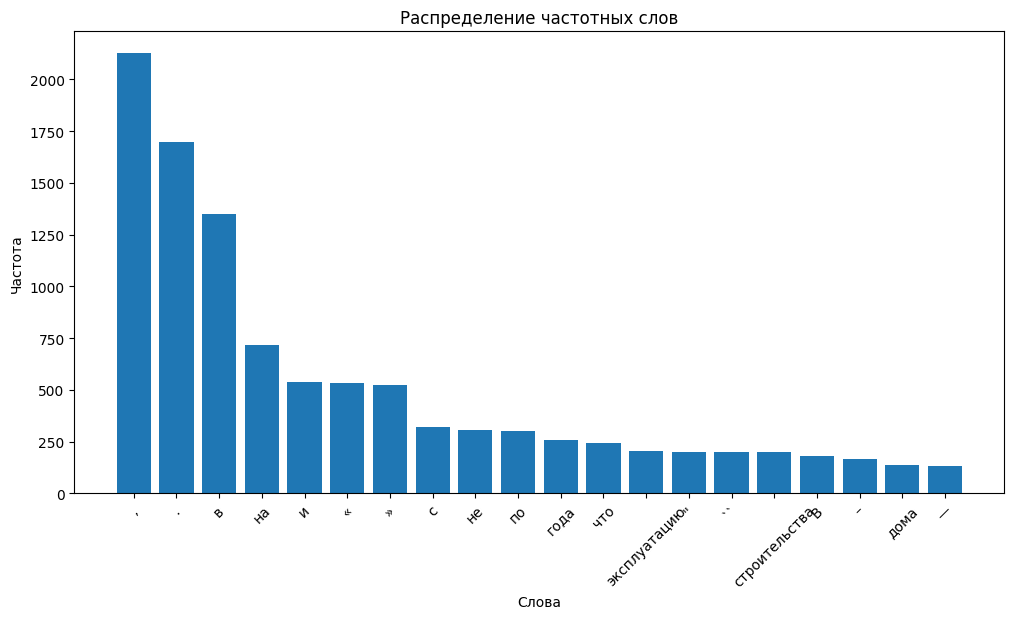

In [ ]:
 most_common_words(train_data, 'sentence')

В топ входят в основном слова не имеющие ценную информации.
Попробуем удалить их.

In [ ]:
import numpy as np
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
# Загрузка списка русских стоп-слов
stop_words = set(stopwords.words('russian'))

# Функция для удаления стоп-слов и пунктуации из текста
def remove_stopwords(text):
    stop_symbols = set(['«', '»', '``', '–', '—', "``", '\'\'']) | {str(i) for i in range(2023)}
    # Токенизация текста
    if text is not np.nan:
      tokens = word_tokenize(text)

      # Удаление стоп-слов и пунктуации
      filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word not in string.punctuation and word not in stop_symbols]

      # Объединение токенов обратно в текст
    else:
      filtered_tokens = []
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_data['filtered_sentence'] = train_data['sentence'].apply(remove_stopwords)

[('года', 261), ('эксплуатацию', 204), ('строительства', 199), ('дома', 139), ('сроков', 109), ('домов', 102), ('ЖК', 93), ('сдачи', 92), ('дольщиков', 87), ('из-за', 86), ('строительство', 85), ('ООО', 85), ('ввода', 83), ('срок', 82), ('году', 80), ('сроки', 79), ('компании', 75), ('области', 74), ('это', 72), ('работы', 70)]


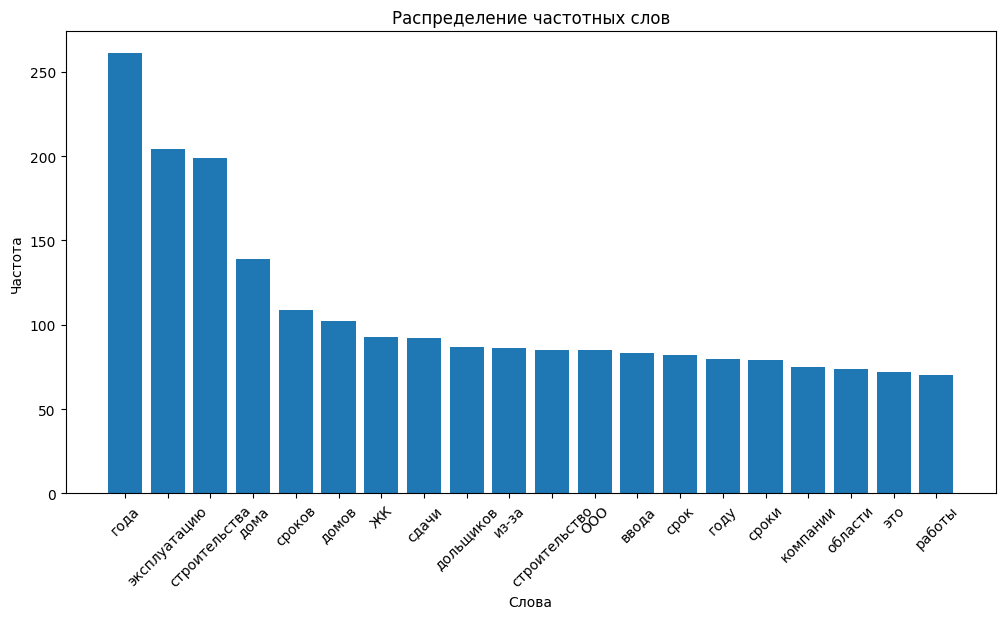

In [ ]:
most_common_words(train_data, 'filtered_sentence')

In [ ]:
def words_and_vocab_sizes(df, feild):
  corpus = ' '.join(df[feild])
  tokens = word_tokenize(corpus)
  all_words = [word for word in tokens]
  VOCAB = sorted(list(set(all_words)))
  print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))


words_and_vocab_sizes(train_data, 'filtered_sentence')

21591 words total, with a vocabulary size of 8303


Посмотрим на размер словаря и количество слов после проведения лемматизации.

In [ ]:
!pip install pymorphy2

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Функция для лемматизации текста
def lemmatize_text(text):
    words = text.split()
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmas)

# Примените функцию лемматизации
train_data['lemmatized_sentence'] = train_data['filtered_sentence'].apply(lemmatize_text)

In [ ]:
words_and_vocab_sizes(train_data, 'lemmatized_sentence')

21591 words total, with a vocabulary size of 4547


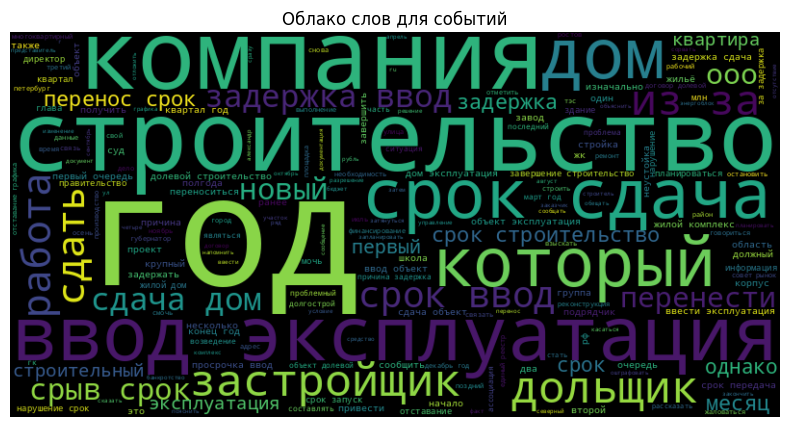

In [ ]:
from wordcloud import WordCloud
# Облако слов для событий
event_sentences = train_data[train_data['label'] == 1]['lemmatized_sentence']
event_wordcloud = WordCloud(width=800, height=400).generate(' '.join(event_sentences))
plt.figure(figsize=(10, 5))
plt.imshow(event_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для событий')
plt.show()

In [ ]:
def split_to_tokens(text):
  return list(text.split())

train_data['tokens'] = train_data['lemmatized_sentence'].apply(split_to_tokens)

In [ ]:
train_data.head()

,sentence,label,filtered_sentence,lemmatized_sentence,tokens
0,Срыв сроков строительства зоопарка оценили в 1...,1,Срыв сроков строительства зоопарка оценили млр...,срыв срок строительство зоопарк оценить млрд р...,"[срыв, срок, строительство, зоопарк, оценить, ..."
1,"По данным Генпрокуратуры РФ, в 2014-2018 годах...",1,данным Генпрокуратуры РФ 2014-2018 годах выяви...,данные генпрокуратура рф 2014-2018 год выявить...,"[данные, генпрокуратура, рф, 2014-2018, год, в..."
2,"Обвиняли в этом столичный акимат, который сорв...",1,Обвиняли столичный акимат который сорвал сроки...,обвинять столичный акимат который сорвать срок...,"[обвинять, столичный, акимат, который, сорвать..."
3,Запуск циклотронного центра ядерной медицины н...,1,Запуск циклотронного центра ядерной медицины б...,запуск циклотронный центр ядерный медицина баз...,"[запуск, циклотронный, центр, ядерный, медицин..."
4,Сроки сдачи объекта несколько раз переносились.,1,Сроки сдачи объекта несколько переносились,срок сдача объект несколько переноситься,"[срок, сдача, объект, несколько, переноситься]"


## Обработка тестовых данных

In [ ]:
test_data['filtered_text'] = test_data['text'].apply(remove_stopwords)
test_data['filtered_title'] = test_data['title'].apply(remove_stopwords)

[('года', 10182), ('декабря', 6332), ('это', 6331), ('году', 6222), ('также', 6070), ('России', 6042), ('области', 5421), ('рублей', 4955), ('которые', 3959), ('время', 3770), ('млн', 3352), ('компании', 3248), ('который', 3125), ('РФ', 3008), ('лет', 3005), ('будут', 2656), ('год', 2555), ('млрд', 2553), ('Это', 2428), ('человек', 2356)]


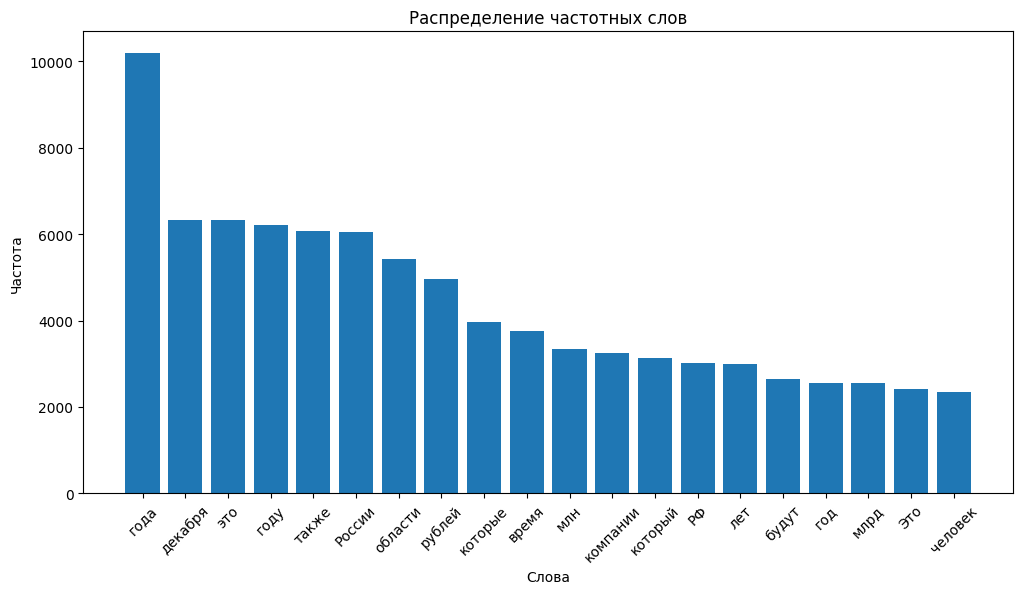

In [ ]:
most_common_words(test_data, 'filtered_text')

[('области', 374), ('России', 299), ('декабря', 290), ('рублей', 246), ('США', 239), ('года', 204), ('из-за', 163), ('млн', 163), ('Шереметьево', 162), ('РФ', 156), ('году', 152), ('млрд', 143), ('год', 125), ('ДТП', 116), ('нефти', 108), ('Сибири', 105), ('Москве', 102), ('СМИ', 100), ('края', 100), ('Петербурге', 89)]


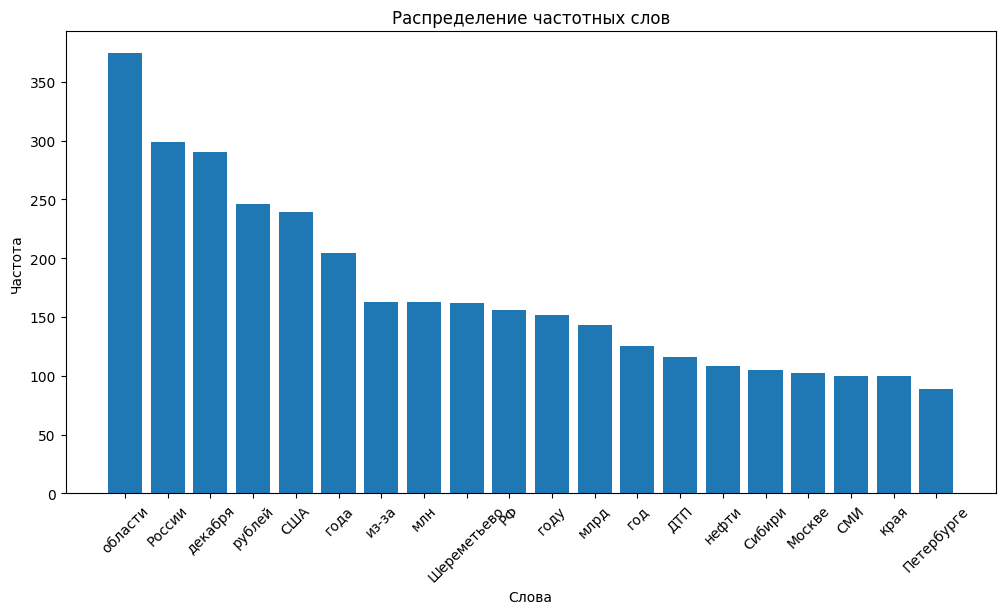

In [ ]:
most_common_words(test_data, 'filtered_title')

In [ ]:
words_and_vocab_sizes(test_data, 'filtered_text')

2119660 words total, with a vocabulary size of 199744


In [ ]:
words_and_vocab_sizes(test_data, 'filtered_title')

72477 words total, with a vocabulary size of 24728


In [ ]:
test_data['lemmatized_title'] = test_data['filtered_title'].apply(lemmatize_text)

In [ ]:
test_data['lemmatized_text'] = test_data['filtered_text'].apply(lemmatize_text)

In [ ]:
words_and_vocab_sizes(test_data, 'lemmatized_text')

2119717 words total, with a vocabulary size of 93248


In [ ]:
words_and_vocab_sizes(test_data, 'lemmatized_title')

72477 words total, with a vocabulary size of 12937


In [ ]:
test_data['title_tokens'] = test_data['lemmatized_title'].apply(split_to_tokens)

In [ ]:
test_data['text_tokens'] = test_data['lemmatized_text'].apply(split_to_tokens)

In [ ]:
test_data['total'] = test_data['lemmatized_title'] + ' ' + test_data['lemmatized_text']

In [ ]:
test_data.head()

,id,title,text,filtered_text,filtered_title,lemmatized_title,lemmatized_text,title_tokens,text_tokens,total
0.0,0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...,соответствии п.42 Постановления Правительства ...,Графики обслуживания внутриквартирного внутрид...,графика обслуживание внутриквартирный внутридо...,соответствие п.42 постановление правительство ...,"[графика, обслуживание, внутриквартирный, внут...","[соответствие, п.42, постановление, правительс...",графика обслуживание внутриквартирный внутридо...
1.0,1,На МЦД улучшили поезда,"В Москве, на Белорусско-Савеловском центрально...",Москве Белорусско-Савеловском центральном диам...,МЦД улучшили поезда,мцд улучшить поезд,москва белорусско-савёловский центральный диам...,"[мцд, улучшить, поезд]","[москва, белорусско-савёловский, центральный, ...",мцд улучшить поезд москва белорусско-савёловск...
2.0,2,Катастрофа SSJ 100: вина за гибель 41 человека...,Завершено расследование дела о крушении самоле...,Завершено расследование дела крушении самолета...,Катастрофа SSJ вина гибель человека возложена ...,катастрофа ssj вино гибель человек возложить п...,завершить расследование дело крушение самолёт ...,"[катастрофа, ssj, вино, гибель, человек, возло...","[завершить, расследование, дело, крушение, сам...",катастрофа ssj вино гибель человек возложить п...
3.0,3,С Днем юриста!,От души поздравляем сотрудников и преподавател...,души поздравляем сотрудников преподавателей ст...,Днем юриста,день юрист,душа поздравлять сотрудник преподаватель студе...,"[день, юрист]","[душа, поздравлять, сотрудник, преподаватель, ...",день юрист душа поздравлять сотрудник преподав...
4.0,4,"Охота на ""черного"" лесоруба","В Костроме прошел межрегиональный форум, посвя...",Костроме прошел межрегиональный форум посвящен...,Охота черного лесоруба,охота чёрный лесоруб,кострома пройти межрегиональный форум посвятит...,"[охота, чёрный, лесоруб]","[кострома, пройти, межрегиональный, форум, пос...",охота чёрный лесоруб кострома пройти межрегион...


In [ ]:
#test_data.to_csv('test_data_EDA.csv', index=False)
#train_data.to_csv('train_data_EDA.csv', index=False)

In [ ]:
#!cp  /content/test_data_EDA.csv /content/drive/MyDrive
#!cp  /content/train_data_EDA.csv /content/drive/MyDrive

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/test_task/test_task/train_data_EDA.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test_task/test_task/test_data_EDA.csv')